In [73]:
# Load from pkl files
import pandas as pd
import pickle


with open('./Input/8-mers/mic_dframe.pkl', 'rb') as file:
    mic_dframe = pickle.load(file)
with open('./Input/8-mers/suscep_classes.pkl', 'rb') as file:
    suscep_classes = pd.read_pickle(file)
    
print(mic_dframe)

        Genome ID  ciprofloxacin  trimethoprim/sulfamethoxazole  ceftriaxone  \
0       590.17802        0.01560                          0.125         0.25   
1       590.13932            NaN                            NaN          NaN   
2       54388.286        0.03120                            NaN          NaN   
3       590.14003        0.01560                          0.125         0.25   
4       590.13436            NaN                            NaN          NaN   
...           ...            ...                            ...          ...   
18213  28901.8277            NaN                            NaN          NaN   
18214   590.14758            NaN                            NaN          NaN   
18215   590.12655            NaN                            NaN          NaN   
18216   590.15152            NaN                            NaN          NaN   
18217   590.14487        0.00781                          0.125         0.25   

       gentamicin  ceftiofur  ampicilli

In [74]:
# Function that creates a dataframe with the number of genomes per class

import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt

def genomes_per_class(df, antibiotics):
    amounts = pd.DataFrame(data={})
    for antibiotic in antibiotics:
        single_amr = df[['Genome ID',antibiotic]].loc[pd.notnull(df[antibiotic])].drop_duplicates()
        if single_amr.shape[0] == 0:
            mics = [4]
            amount = [0]
        else:
            # Unique mic values
            mics = df[antibiotic].loc[pd.notnull(df[antibiotic])].sort_values().unique()
            amount = [len(single_amr.loc[single_amr[antibiotic]==mic]) for mic in mics]
            amount = pd.DataFrame(amount, index=mics).T
        # Fiz uma alteracao para funcionar no pandas mais recente.
        amounts = pd.concat([amounts, amount], sort=True, ignore_index=True)
        #---------------------------------------------------------------
    return amounts

def susceptibility_heatmap(data, annot, antibiotics, title):
    sns.set_theme(font_scale=.8, style='white')
    myColors = ((0.0, 0.8, 0.0, 1.0), (0.0, 0.8, 0.8, 1.0), (0.8, 0.0, 0.0, 1.0))
    cmap = LinearSegmentedColormap.from_list('Custom', myColors, len(myColors))
    # Abbreviate the antibiotic names to 5 letters
    antibiotic_abbre = {i:antibiotics[i][:5].upper() for i in range(len(antibiotics))}
    # Number of genomes by Antibiotic and MIC.
    data = data.rename(index=antibiotic_abbre)
    # Set the width and height of the figure
    plt.figure(figsize=(10,6))
    # Add title
    plt.title(title, fontsize=12)
    # Heatmap showing the amount of genomes with the same MIC for each MIC, by antibiotic
    hp = sns.heatmap(data=data, annot=annot, cmap=cmap, fmt='.4g')
    # Manually specify colorbar labelling after it's been generated
    colorbar = hp.collections[0].colorbar
    colorbar.set_ticks([0.333, 1, 1.667])
    colorbar.set_ticklabels(['Susceptible', 'Intermediate', 'Resistant'])
    colorbar.ax.tick_params(labelsize=12)
    # Add label for horizontal axes
    plt.xlabel('MIC (micrograms per milliliter)', fontsize=12)
    plt.ylabel('Antibiotic', fontsize=12)

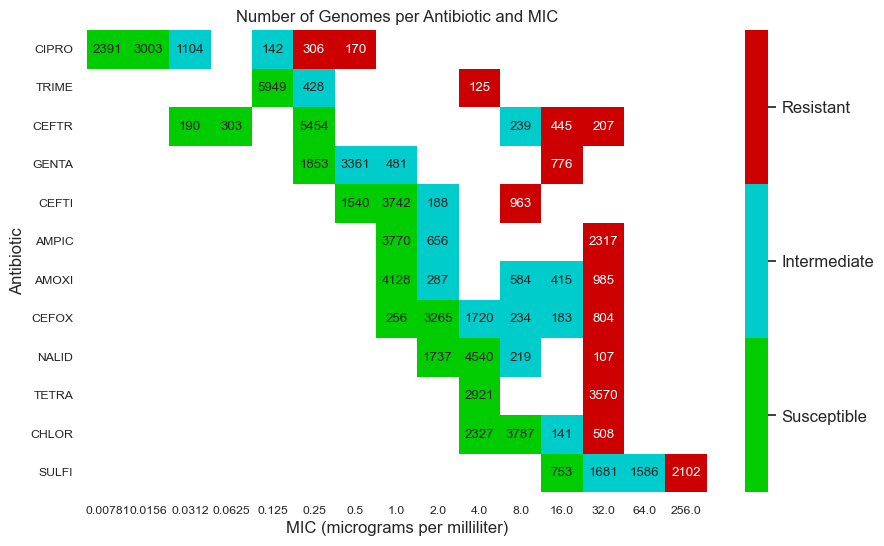

In [75]:
# Antibiotics
antibiotics = mic_dframe.columns[-12:]

# Comupute the distribution of MIC measurements
mic_distribution = genomes_per_class(mic_dframe, antibiotics)

# Combine the MIC distribution and the susceptibility map
title = 'Number of Genomes per Antibiotic and MIC'
susceptibility_heatmap(data=suscep_classes, annot=mic_distribution, antibiotics=antibiotics, title=title)

In [76]:
# Load the k-mer basis of k-mer counts

kmers = np.load('./input/8-mers/kmers_basis.npy')

print(kmers)
print('size = {}'.format(kmers.shape[0]))

['AAAAAAAA' 'AAAAAAAC' 'AAAAAAAG' ... 'TTTTTTTC' 'TTTTTTTG' 'TTTTTTTT']
size = 65537


In [77]:
# Load a k-mer count example

count = np.load('./input/8-mers/counts/1079901.3.npy')

print(count)
print('size = {}'.format(count.shape[0]))

[171 230 212 ... 231 205 149]
size = 65537


In [78]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

def best_N_features(target_df, antibiotic, N):
    path = './input/8-mers/counts/'
    genome_ids = target_df['Genome ID'].loc[pd.notnull(target_df[antibiotic])].values
    X = np.array([np.load(path + genome_id + '.npy') for genome_id in genome_ids])
    y = target_df[antibiotic].loc[pd.notnull(target_df[antibiotic])].values
    n_best = SelectKBest(chi2, k=N)
    X_new = n_best.fit_transform(X, y*10**5)
    kmers = np.load('./input/8-mers/kmers_basis.npy')
    selected_kmers = [column[0]  for column in zip(kmers, n_best.get_support()) if column[1]]
    #scores = k_best.fit(X,y).scores_
    best_feature_df = pd.DataFrame(X_new, columns = selected_kmers)
    return best_feature_df

kmer_dframe = best_N_features(target_df=mic_dframe, antibiotic='ampicillin', N=200)

print(kmer_dframe)

      AAAAATCA  AAAAGAAA  AAAGCATC  AACGCTCA  AAGAAAAG  AAGAACGC  AAGCATCA  \
0          271       210       101       106       130        89        96   
1          303       236       112       118       145       111        98   
2          264       212        81       103       128        89        86   
3          291       205        94        99       128        93        86   
4          246       193        84        83       121        86        65   
...        ...       ...       ...       ...       ...       ...       ...   
6789       294       198        92        96       143        96        87   
6790       278       215        86       109       110        89        93   
6791       291       228        95       110       123        99        92   
6792       284       229        99       115       108       113        86   
6793       244       177       105        92        99        77        93   

      AAGGCCTT  AAGGGGAT  AATGAAAT  ...  TGGTGGCA  TTCAGCTT  TT

In [79]:
# Define the features input (X) and the target output (y) variables

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

# Select the antibiotic
antibiotic = 'ampicillin'

# Features
X = kmer_dframe.values

# Standardize the input data
scaler_X = StandardScaler().fit(X)
X_scaled = scaler_X.transform(X)

# Target
# list of MIC values
y = mic_dframe[antibiotic].loc[pd.notnull(mic_dframe[antibiotic])].values
# reshape the list of mics
y_reshape = np.reshape(y,(-1,1))
# define encoder function
encoder = OneHotEncoder(sparse_output=False)
# transform the target categorical data to onehot code
y_onehot = encoder.fit_transform(y_reshape)

# Split into the training and test data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_onehot, test_size=0.1, random_state=0)

In [80]:
# Define the classification model
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

# Model building function
def make_model(optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['categorical_accuracy'],):
    
    model = keras.Sequential([
        layers.Dense(64, activation='relu', input_shape=[X.shape[1]]),
        layers.Dense(y_onehot.shape[1], activation='softmax'),
    ])

    # Add the cross-entropy loss and accuracy metric for threshold probability
    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=metrics,
    )
    
    return model

# Define the model
model = make_model()

# Include an early stopping callback for convenience
early_stopping = keras.callbacks.EarlyStopping(
    # monitor (loss or val_loss)
    monitor='val_loss',
    # how many epochs to wait before stopping (minimum epochs)
    patience=100,
    # minimium amount of change to count as an improvement
    min_delta=0.001,
    restore_best_weights=True,
)

/Applications/miniconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [81]:
def class_weighting(df, antibiotic, cv):
    # Unique mic values
    mics = df[antibiotic].loc[pd.notnull(df[antibiotic])].unique()
    # Samples per class
    samples = {mic : len(df.loc[df[antibiotic]==mic]) for mic in mics}
    # Sorted classes
    mics = sorted([key for key in samples.keys()])
    # total data
    total = len(df.loc[pd.notnull(df[antibiotic])])
    # class weights
    class_weight = {i: (1 / samples[mic])*(total/len(mics))*(1/cv) for i, mic in enumerate(mics)}
    
    return class_weight

class_weight = class_weighting(mic_dframe, antibiotic, cv=1)

print(class_weight)

{0: 0.5929999127171162, 1: 3.441742654508612, 2: 0.9774133218241979}


In [82]:
# Training with early stopping and class weights

import time

starttime = time.time()

history = model.fit(
    X_train, y_train,
    shuffle=True,
    validation_split=0.3,
    #validation_data=(X_valid, y_valid),
    batch_size=1024,
    epochs=1000,
    callbacks=[early_stopping],
    class_weight = class_weight,
    verbose=0, # hide the output because we have so many epochs
)

print('Training Time: {:0.2f} seconds'.format(time.time() - starttime))

Training Time: 4.90 seconds


Best Validation Loss: 0.66
Best Validation Accuracy: 0.76


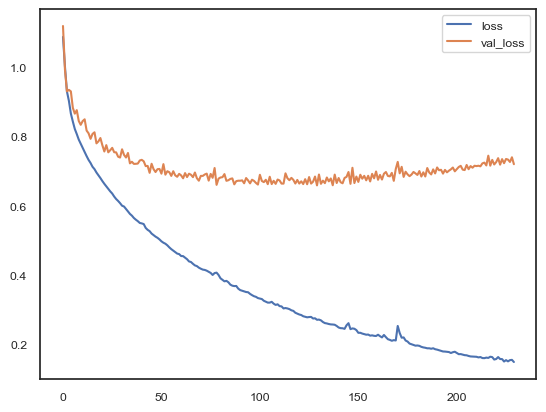

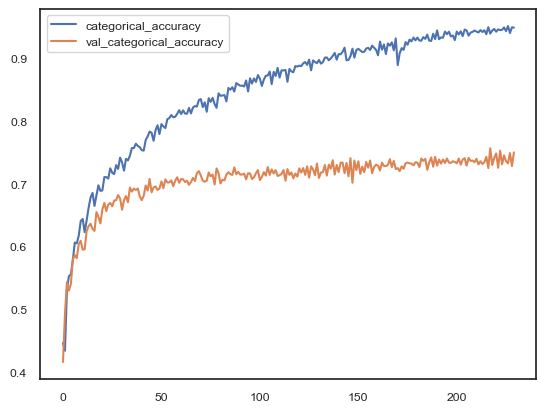

In [83]:
# Plot the loss (accuracy) and validation loss (accuracy) functions

history_df = pd.DataFrame(history.history)
# Start the plot at epoch 5
history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['categorical_accuracy', 'val_categorical_accuracy']].plot()

print(("Best Validation Loss: {:0.2f}" +\
      "\nBest Validation Accuracy: {:0.2f}")\
      .format(history_df['val_loss'].min(), 
              history_df['val_categorical_accuracy'].max()))

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 673us/step


Text(0.5, 26.249999999999993, 'Predicted label')

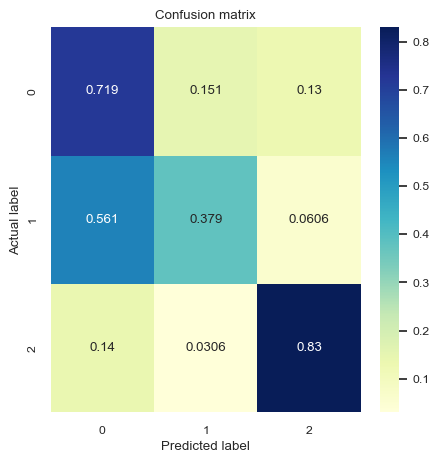

In [84]:
# Make predictions and compute the confusion matrix

from sklearn.metrics import confusion_matrix

# Make predictions and decode the OneHot
mics_pred = [str(item[0]) for item in encoder.inverse_transform(model.predict(X_test))]
# True mic values in string format
mics_test = [str(item[0]) for item in encoder.inverse_transform(y_test)]
# Unique mic values
mics = [str(mic) for mic in sorted(mic_dframe[antibiotic].loc[pd.notnull(mic_dframe[antibiotic])].unique())]
# Compute the confusion matrix
cm = confusion_matrix(mics_test, mics_pred, normalize='true', labels=mics)
# Plot the cm
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt='.3g', cmap="YlGnBu")
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 242us/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step


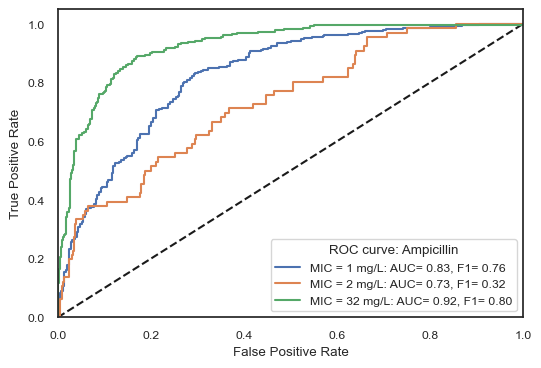

In [85]:
from sklearn.metrics import roc_curve, auc, f1_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC

def plot_multiclass_roc(clf, X_test, y_test, labels, antibiotic):
    # predicted target
    y_pred= model.predict(X_test)
    # 1-dimension test and predicted values
    y_test_1d = [str(item[0]) for item in encoder.inverse_transform(y_test)]
    y_pred_1d = [str(item[0]) for item in encoder.inverse_transform(model.predict(X_test))]
    
    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    # roc curves
    for i in range(len(mics)):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    f1 = f1_score(y_test_1d, y_pred_1d, average=None)
    # roc for each class
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    #ax.set_title('Receiver operating characteristic example')
    for i in range(len(mics)):
        ax.plot(fpr[i], tpr[i], label='MIC = %i mg/L: AUC= %0.2f, F1= %0.2f' % (mics[i], roc_auc[i], f1[i]))
    ax.legend(loc="best")
    # Add legend
    plt.legend(title='ROC curve: '+antibiotic[0].upper()+antibiotic[1:])
    plt.show()
    
    
# Unique mic values
mics = sorted(np.unique(y))
plot_multiclass_roc(model, X_test, y_test, labels=mics, antibiotic=antibiotic)

In [86]:
def kfold_cv_split(X, y, n_splits, kfold):

    total_data = len(X)
    fold_size = total_data // n_splits
    X_folds = []
    y_folds = []
    for i in range(n_splits):
        start  = i * fold_size
        if i < n_splits-1:
            end = start + fold_size
        else:
            end = total_data
        X_folds.append(X[start:end,:])
        y_folds.append(y[start:end])
    
    if kfold == 0:
        train   = kfold + n_splits-2
        val         = kfold + n_splits-2
        test        = kfold + n_splits-1
        X_train, X_val, X_test = np.concatenate(X_folds[kfold:train]), X_folds[val], X_folds[test]
        y_train, y_val, y_test = np.concatenate(y_folds[kfold:train]), y_folds[val], y_folds[test]
        
    elif kfold == 1:
        train   = kfold + (n_splits-2)
        val         = kfold + (n_splits-2)
        test        = kfold + (n_splits-1) - n_splits
        X_train, X_val, X_test = np.concatenate(X_folds[kfold:train]), X_folds[val], X_folds[test]
        y_train, y_val, y_test = np.concatenate(y_folds[kfold:train]), y_folds[val], y_folds[test]
        
    elif kfold == 2:
        train   = kfold + (n_splits-2)
        val         = kfold + (n_splits-2) - n_splits
        test        = kfold + (n_splits-1) - n_splits
        X_train, X_val, X_test = np.concatenate(X_folds[kfold:train]), X_folds[val], X_folds[test]
        y_train, y_val, y_test = np.concatenate(y_folds[kfold:train]), y_folds[val], y_folds[test]
    
    else:
        train   = kfold + (n_splits-2) - n_splits
        val         = kfold + (n_splits-2) - n_splits
        test        = kfold + (n_splits-1) - n_splits
        X_train, X_val, X_test = np.concatenate((np.concatenate(X_folds[kfold:]),np.concatenate(X_folds[:train]))), X_folds[val], X_folds[test]
        y_train, y_val, y_test = np.concatenate((np.concatenate(y_folds[kfold:]),np.concatenate(y_folds[:train]))), y_folds[val], y_folds[test]
    
    return X_train, X_val, X_test, y_train, y_val, y_test


def kfold_cross_val(X, y, cv):
    n_splits=cv
    kfold_accuracy = []
    for kfold in range(n_splits):
        # Split into the training, validation and test data
        X_train, X_val, X_test, y_train, y_val, y_test = kfold_cv_split(X, y, n_splits, kfold)
        # Define the model
        model = make_model()
        # Training
        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            batch_size=1024,
            epochs=1000,
            callbacks=[early_stopping],
            class_weight = class_weights,
            verbose=0,
        )
        # Make predictions, compute the confusion matrix and extract the (per-class) accuracy
        mic_pred = [str(item[0]) for item in encoder.inverse_transform(model.predict(X_test))]
        mic_test = [str(item[0]) for item in encoder.inverse_transform(y_test)]
        cm = confusion_matrix(mic_test, mic_pred, normalize='true')
        accuracy = 100*np.diagonal(cm)
        # Save the accuracy per fold
        kfold_accuracy.append(accuracy)
    # Get the average (per-class) accuracy from k-fold cross-validation
    average_accuracy= [a.mean() for a in np.transpose(kfold_accuracy)]
    return average_accuracy

In [ ]:
# Initialize a vector to save the average accuracy per antibiotic

#average_accuracies = []
average_accuracies = pd.DataFrame(data={})
for antibiotic in antibiotics:
    
    start_time = time.time()
    
    # Features
    kmer_dframe = best_N_features(target_df=mic_dframe, antibiotic=antibiotic, N=300)
    X = kmer_dframe.values
    
    # Standardize the training data
    scaler_X = StandardScaler().fit(X)
    X_scaled = scaler_X.transform(X)

    # Target
    y = mic_dframe[antibiotic].loc[pd.notnull(mic_dframe[antibiotic])].values
    y_reshape = np.reshape(y,(-1,1))
    encoder = OneHotEncoder(sparse_output=False)
    y_onehot = encoder.fit_transform(y_reshape)
    
    # Class weighting
    class_weights = class_weighting(mic_dframe, antibiotic, cv=5)
    
    # Start modeling
    start_modeling_time = time.time()

    # Get the average (per-class) accuracy from k-fold cross-validation
    average_accuracy = kfold_cross_val(X_scaled, y_onehot, cv=5)
    
    # Save dataframes with the average accuracy per mic value
    mics = sorted(np.unique(y))
    #average_accuracies.append(pd.DataFrame(average_accuracy, index=mics).T)
    average_accuracies = pd.concat([average_accuracies, pd.DataFrame(average_accuracy, index=mics).T], sort=True, ignore_index=True)
    
    final_modeling_time = time.time()
    
    final_time = time.time()
    
    print('Time: {:0.2f} s, Modeling Time: {:0.2f} s'.format(final_time - start_time, final_modeling_time - start_modeling_time))      

# Overall average accuracy
overall_accuracy = average_accuracies

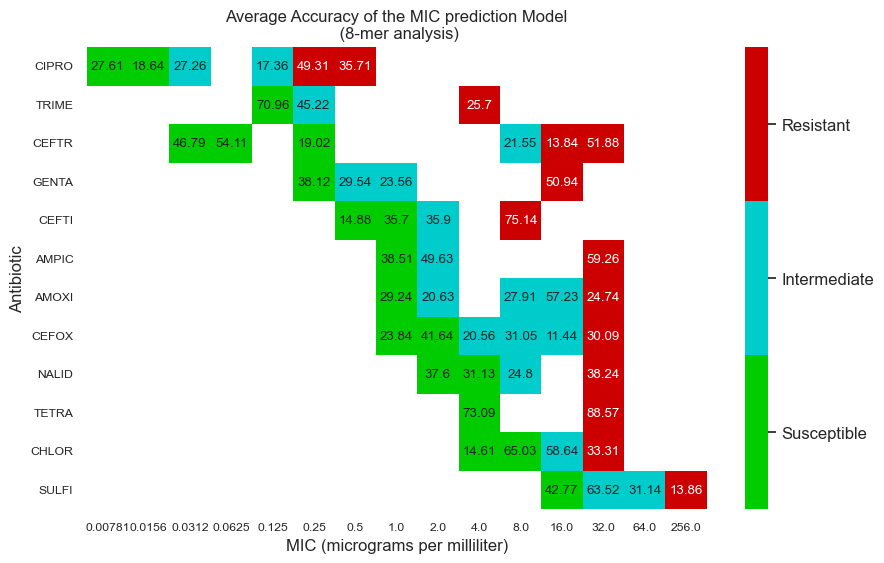

In [88]:
# Plot the overall average accuracy

title = 'Average Accuracy of the MIC prediction Model\n (8-mer analysis)'
susceptibility_heatmap(data=suscep_classes, annot=overall_accuracy, antibiotics=antibiotics, title=title)